In [46]:
import os
import pickle as pk
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape
from keras.models import Model, Sequential
from keras import backend as K
import numpy as np
from sklearn.cluster import KMeans
from time import time
from sklearn.model_selection import train_test_split
from skimage import transform
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.models import model_from_json

In [47]:
with open("D:\\vuchef\\electrica\\dirigido\\datos_filtrados.p","rb") as f:
    datos = pk.load(f)
print(np.shape(datos))
y = np.loadtxt('D:\\vuchef\\electrica\\dirigido\\clases.txt',delimiter = ',')
print(np.shape(y))

(31228, 63, 63)
(31228,)


In [48]:
# load json and create model
json_file = open('D:\\vuchef\\electrica\\dirigido\\final\\model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)
# load weights into new model
autoencoder.load_weights("D:\\vuchef\\electrica\\dirigido\\final\\model.h5")
print("Loaded model from disk")

Loaded model from disk


In [49]:
def resize_batch(imgs):
    imgs = imgs.reshape((-1, 63, 63, 1))
    resized_imgs = np.zeros((imgs.shape[0], 64, 64, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (64, 64))
    return resized_imgs


In [50]:
nuevo = resize_batch(datos)
print(np.shape(nuevo))

(31228, 64, 64, 1)


In [51]:
# load json and create model
json_file = open('D:\\vuchef\\electrica\\dirigido\\final\\encoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
encoder = model_from_json(loaded_model_json)
# load weights into new model
encoder.load_weights("D:\\vuchef\\electrica\\dirigido\\final\\encoder.h5")
print("Loaded model from disk")

Loaded model from disk


In [52]:
# load json and create model
json_file = open('D:\\vuchef\\electrica\\dirigido\\final\\decoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
decoder = model_from_json(loaded_model_json)
# load weights into new model
decoder.load_weights("D:\\vuchef\\electrica\\dirigido\\final\\decoder.h5")
print("Loaded model from disk")

Loaded model from disk


In [53]:
encoded_imgs = encoder.predict(nuevo)
decoded_imgs = decoder.predict(encoded_imgs)

# Separacion por clases

In [54]:
a = []
b = []
c = []
d = []
e = []
for i in range(np.shape(nuevo)[0]):
    if y[i]==0:
        a.append(i)
    elif y[i]==1:
        b.append(i)
    elif y[i]==2:
        c.append(i)
    elif y[i]==3:
        d.append(i)
    else:
        e.append(i)
print('AGN:',len(a),'SN:',len(b),'VS:',len(c),'Asteroid:',len(d),'Bogus',len(e))

AGN: 8721 SN: 987 VS: 9772 Asteroid: 9797 Bogus 1951


In [55]:
numero_datos = len(b)
clases = np.zeros(5*len(b))
prueba = np.zeros((len(b)*5,64,64,1))
for i in range(numero_datos):
    prueba[i,:,:,:] = nuevo[int(a[i]),:,:,:]
    clases[i] = 0
    prueba[numero_datos+i,:,:,:] = nuevo[int(b[i]),:,:,:]
    clases[numero_datos+i] = 1
    prueba[2*numero_datos+i,:,:,:] = nuevo[int(c[i]),:,:,:]
    clases[2*numero_datos+i] = 2
    prueba[3*numero_datos+i,:,:,:] = nuevo[int(d[i]),:,:,:]
    clases[3*numero_datos+i] = 3
    prueba[4*numero_datos+i,:,:,:] = nuevo[int(e[i]),:,:,:]
    clases[4*numero_datos+i] = 4

In [56]:
BOGUS_ls = np.zeros((len(e),1,1,10))
SN_ls = np.zeros((len(b),1,1,10))
BOGUS_r = np.zeros((len(e),64,64))
SN_r = np.zeros((len(b),64,64))
BOGUS = np.zeros((len(e),63,63))
SN = np.zeros((len(b),63,63))

In [59]:
for i in range(len(e)):
    valor = int(e[i])
    BOGUS_ls[i,:,:] = encoded_imgs[valor,:,:]
    BOGUS_r[i,:,:] = decoded_imgs[valor,:,:,0]
    BOGUS[i,:,:] = datos[valor,:,:]
    
for i in range(len(b)):
    valor = int(b[i])
    SN_ls[i,:,:] = encoded_imgs[valor,:,:]
    SN_r[i,:,:] = decoded_imgs[valor,:,:,0]
    SN[i,:,:] = datos[valor,:,:]

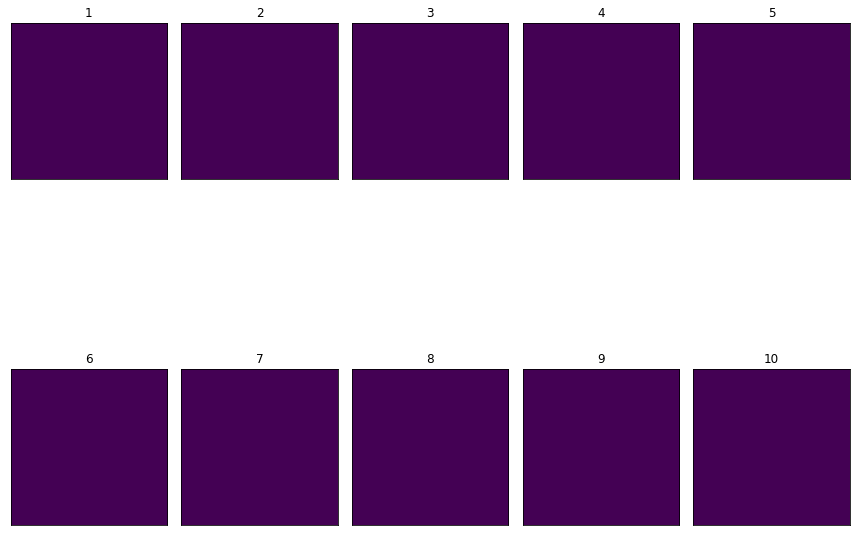

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


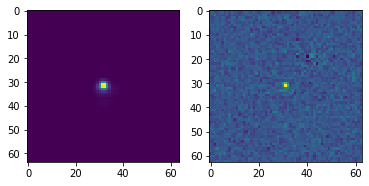

In [60]:
imagen = 22


plt.subplot(121)


plt.subplot(121)
plt.imshow(SN_r[int(imagen),:,:])

plt.subplot(122)
plt.imshow(SN[int(imagen),:,:])
plt.show()

# Cluster sobre el espacio latente

In [61]:
flatten = Sequential()
flatten.add(encoder)
flatten.add(Flatten())

In [62]:
imagenes = flatten.predict(prueba)
print(np.shape(imagenes))

(4935, 10)


In [63]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Distintos valores de perplexity

In [64]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=5, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

<Figure size 432x288 with 0 Axes>

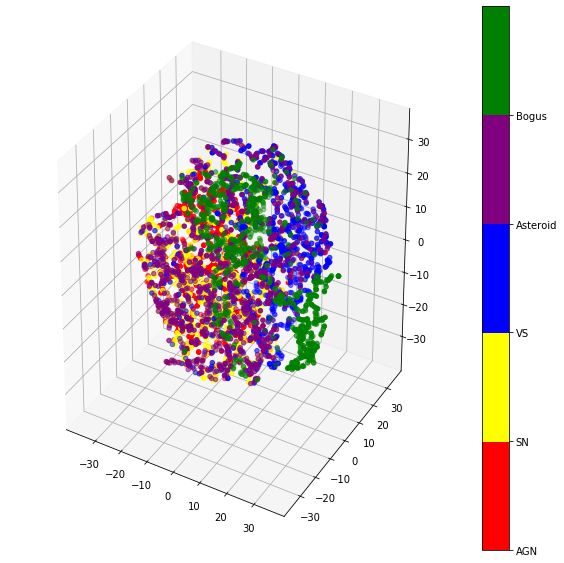

In [65]:
fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

In [66]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=10, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

<Figure size 432x288 with 0 Axes>

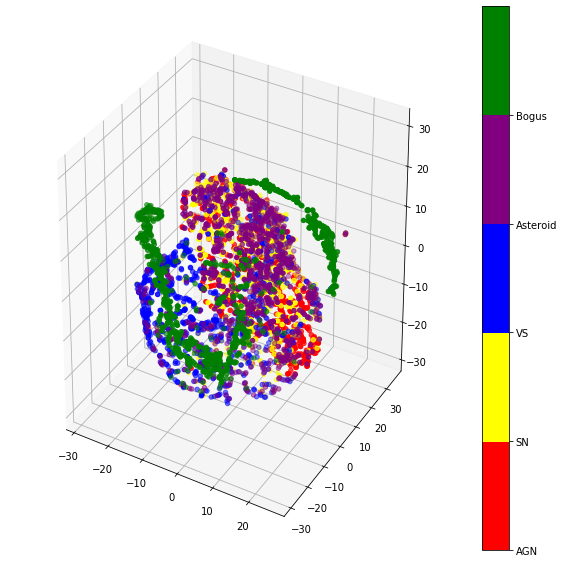

In [67]:
fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

In [68]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=20, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

<Figure size 432x288 with 0 Axes>

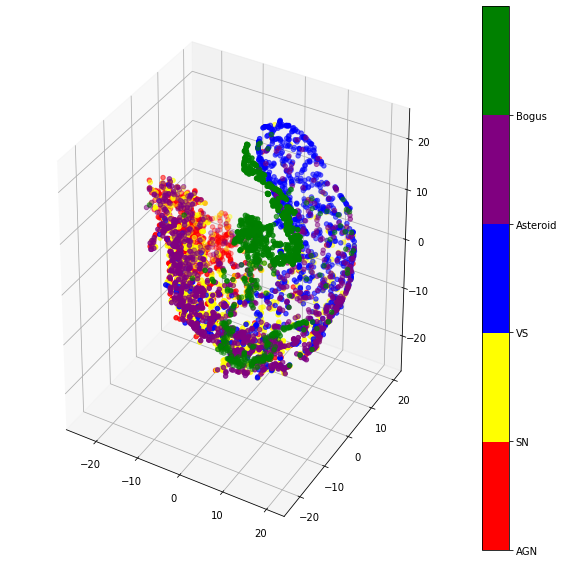

In [69]:
fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

In [70]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

<Figure size 432x288 with 0 Axes>

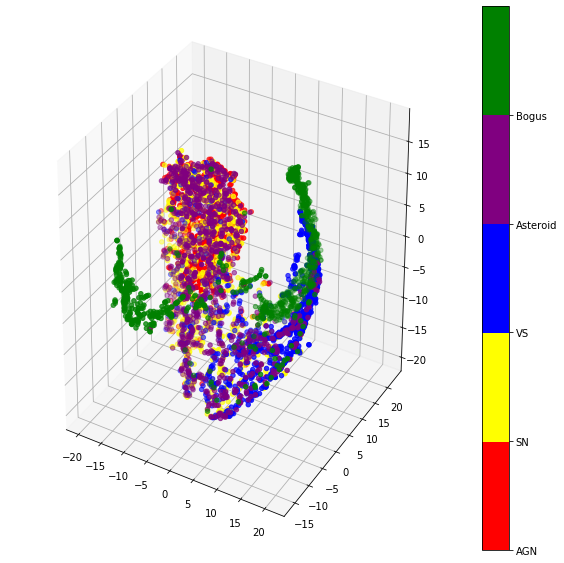

In [71]:
fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

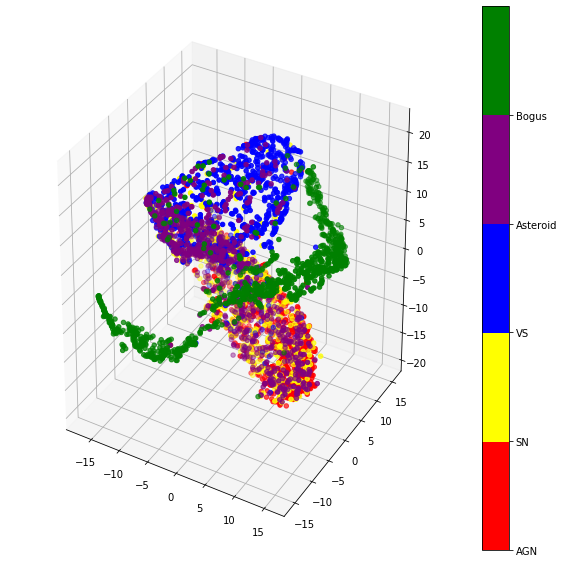

In [72]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

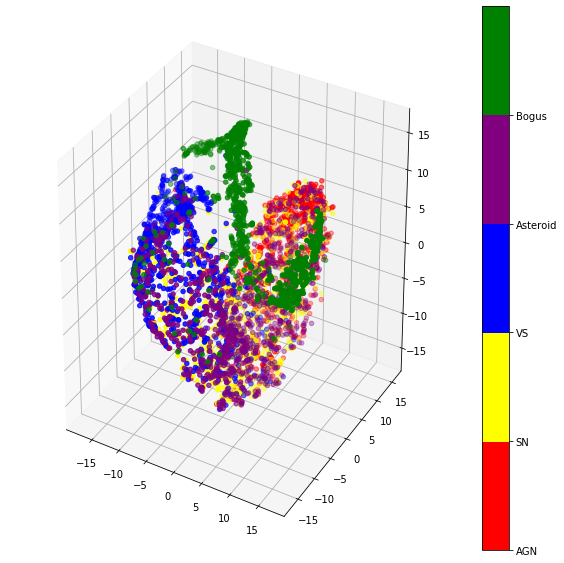

In [73]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

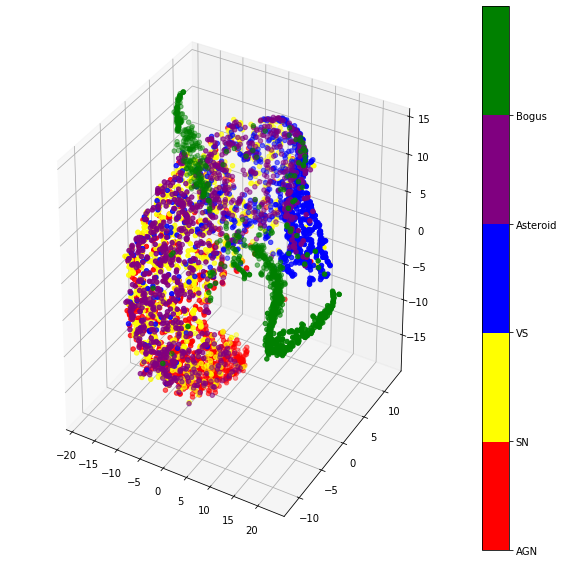

In [74]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=60, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

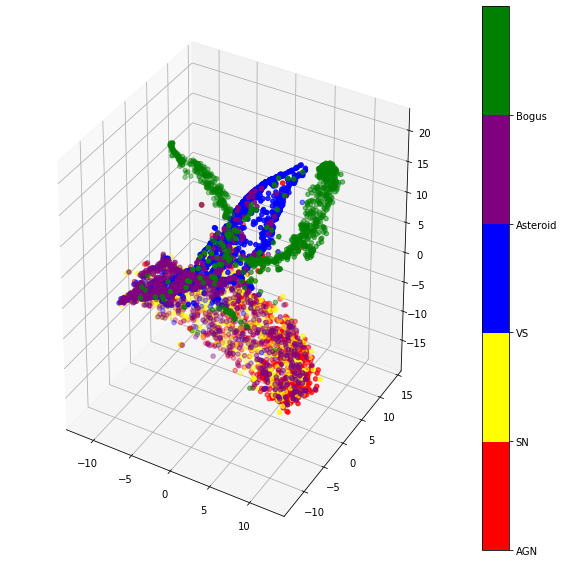

In [75]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=70, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

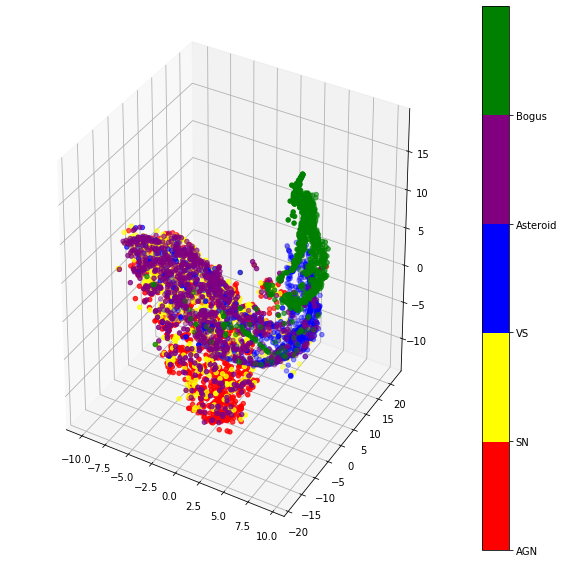

In [76]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

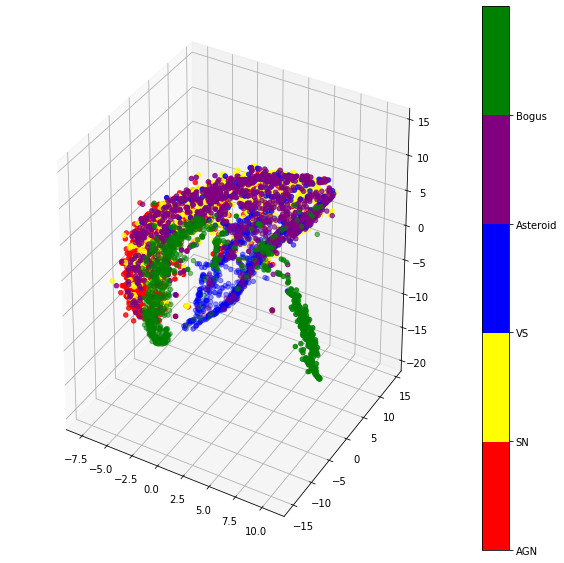

In [77]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

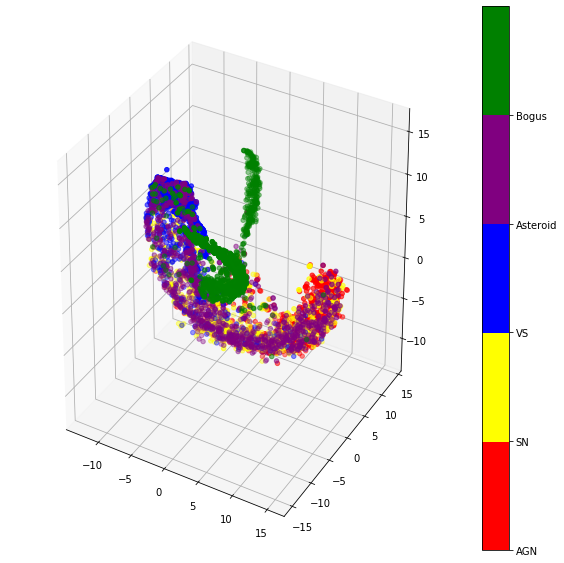

In [78]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

# Distintos learning rate, con perplexity = 80

<Figure size 432x288 with 0 Axes>

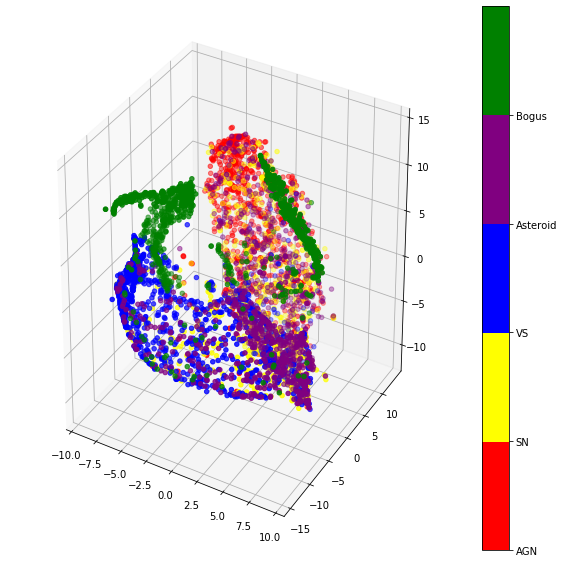

In [79]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 10)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

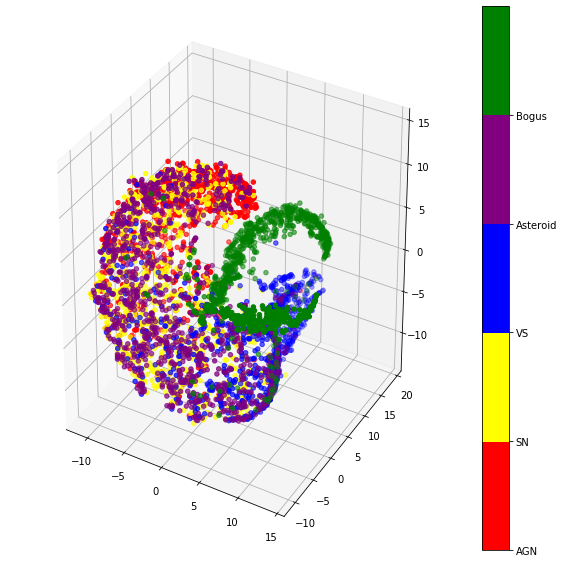

In [80]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 40)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

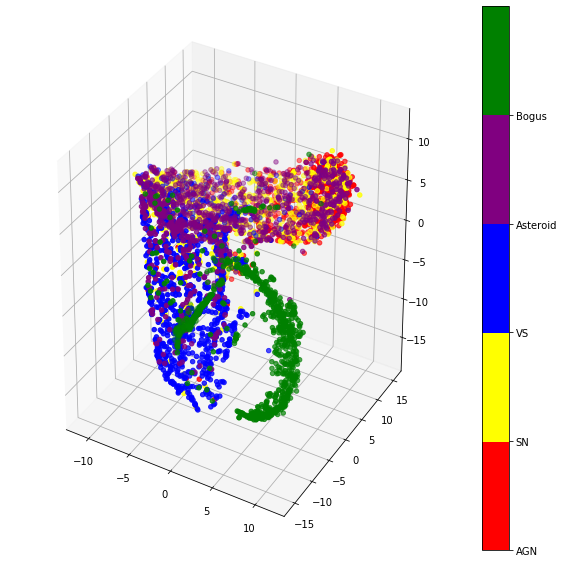

In [81]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 100)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

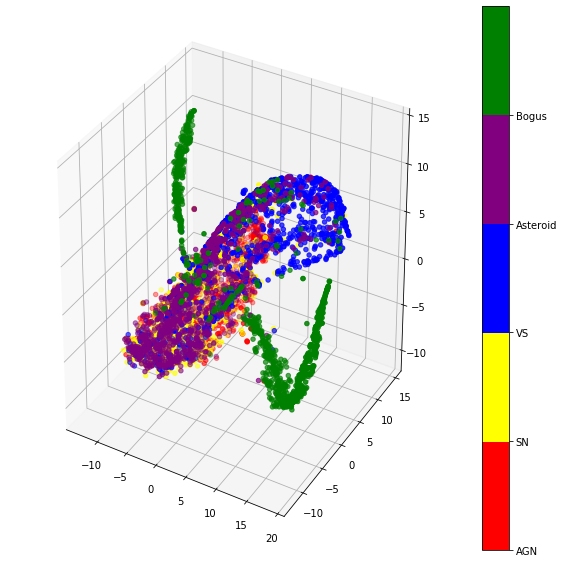

In [82]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 300)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

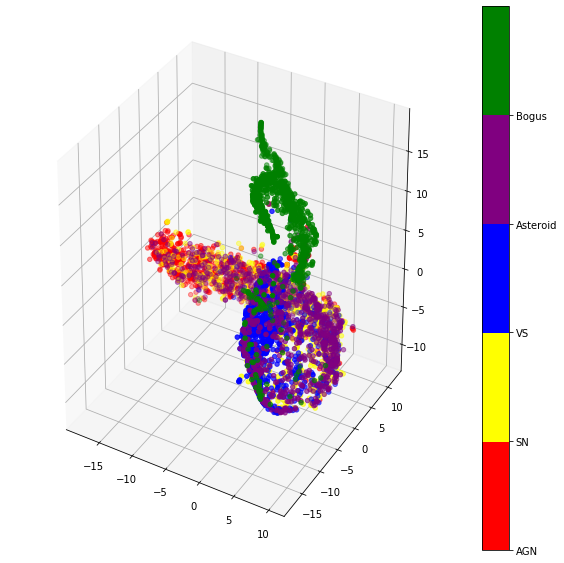

In [83]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 500)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

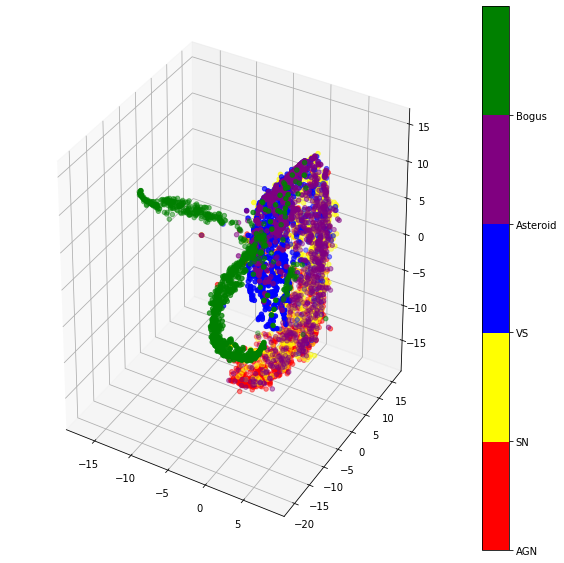

In [84]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 700)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

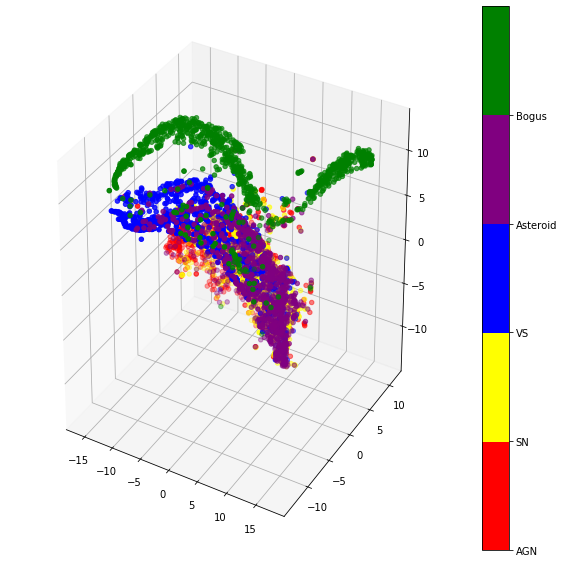

In [85]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 800)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

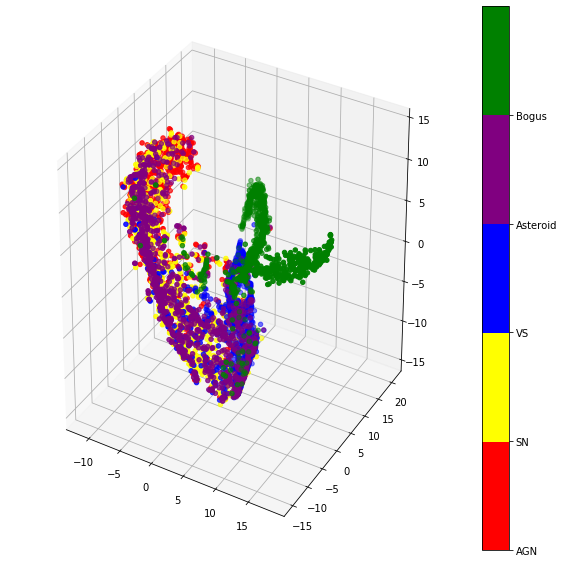

In [86]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 900)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()

<Figure size 432x288 with 0 Axes>

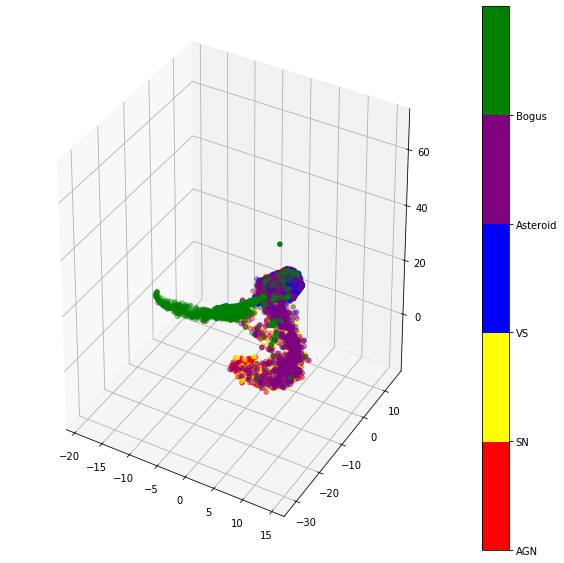

In [87]:
from sklearn.manifold import TSNE
import time

tsne = TSNE(n_components=3, verbose=0, perplexity=80, n_iter=1000,learning_rate = 1000)
tsne_results = tsne.fit_transform(imagenes)

fig = plt.figure()
colors = ['red','yellow','blue','purple','green']
nombres = ['AGN','SN','VS','Asteroid','Bogus']
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
p = ax.scatter3D(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2], c=clases, cmap=matplotlib.colors.ListedColormap(colors));
d = plt.colorbar(p)
loc = np.arange(0,max(y),max(y)/float(len(colors)))
d.set_ticks(loc)
d.set_ticklabels(nombres)
plt.show()